In [44]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
parent_dir = os.path.abspath("../papers/Attention Is All You Need")
sys.path.append(parent_dir)
from pathlib import Path
from tqdm import tqdm

In [45]:
import yaml

YAML_PATH = Path("../")  / "papers" / "Attention Is All You Need" / "config.yaml"
with open(YAML_PATH, "r") as file:
    config = yaml.safe_load(file)

## Get Training Data and Encode Training Data

In [34]:
from BPE.bpe import BPEEncoder, BPEDecoder


In [35]:
PATH = Path("../")  / "data" / "EnglishGerman" 
dataset = pd.read_csv(PATH / "wmt14_translate_de-en_validation.csv")

In [36]:
BPE_PATH = Path("../")  / "papers" / "Attention Is All You Need" / "BPE" 
with open(BPE_PATH / "vocab_merges_2500.pkl", "rb") as f:
    vocab = pickle.load(f)

In [8]:
bpe_encoder = BPEEncoder(vocab=vocab)
english_encoded = bpe_encoder.encode(dataset.iloc[:, 1])
german_encoded = bpe_encoder.encode(dataset.iloc[:, 0])

## Preparing the Data

In [16]:
max_vocab_size = max(vocab.values())
special_tokens = {max_vocab_size + 1 : "<SOS>",  max_vocab_size + 2 : "<EOS>", max_vocab_size + 3 : "<pad>"}
bpe_decoder = BPEDecoder(vocab=vocab, special_tokens=special_tokens)

In [17]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings, tgt_encodings, output_encodings))
        full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
        src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
        src_tensor = torch.tensor(src_seq, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
        output_tensor = torch.tensor(output_seq, dtype=torch.long)

        src_tensor = F.pad(src_tensor, (0, self.seq_len - src_tensor.size(0)), value=self.pad_token)
        tgt_tensor = F.pad(tgt_tensor, (0, self.seq_len - tgt_tensor.size(0)), value=self.pad_token)
        output_tensor = F.pad(output_tensor, (0, self.seq_len - output_tensor.size(0)), value=self.pad_token)
        encoder_mask = (src_tensor != self.pad_token).int()

        subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
        padding_mask = (tgt_tensor != self.pad_token).int()
        decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

        

        return {
            "src": src_tensor, # Seq_len
            "tgt": tgt_tensor, # seq_len
            "output": output_tensor, # seq_len
            "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
            "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
        }

    def __len__(self): 
        return len(self.paired_encodings)

In [18]:
full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=german_encoded, sos_token=max_vocab_size + 1, eos_token=max_vocab_size + 2,
                                        pad_token=max_vocab_size + 3)

train_data, test_data = random_split(full_data, [config['TRAIN_RATIO'], 1-config['TRAIN_RATIO']])

NameError: name 'english_encoded' is not defined

In [12]:
train_dataloader = DataLoader(train_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)

## Model Creation

In [46]:
from TransformerComponents.Encoder import Encoder
from TransformerComponents.Decoder import Decoder
from TransformerComponents.PE import PositionalEmbedding
from TransformerComponents.Transformer import Transformer
from TransformerComponents.UtilsLayers import Projection

In [47]:
vocab_size = len(vocab) + 256 + 3 # 3 special tokens
vocab_size = 8000

In [53]:
encoder_transformer = Encoder(config['N_ENCODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
decoder_transformer = Decoder(config['N_DECODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
src_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
# tgt_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
projection = Projection(config['D_MODEL'], vocab_size)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(encoder_transformer, decoder_transformer, src_embeddings, tgt_embeddings, projection).to(device)

In [55]:
model.initialise()

## Model Training

In [18]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    encoder_input = batch['src'].to(device) # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device) # B  x 1 x 1 x seq_len
    encoder_output = model.encode(encoder_input, encoder_mask)
    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[: , 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1) # shape: (B, max_len, max_len)
        other_mask =(decoder_input != pad_token).int().unsqueeze(1) # (B, 1, max_len)
        out = model.decode(decoder_input, encoder_output, encoder_mask, (subsequent_mask & other_mask).unsqueeze(1).to(device))
        prediction = model.proj(out) # Expected shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1) # shape: (B, )
        next_tokens = torch.where(finished, pad_token, next_tokens)

        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)

        if finished.all():
          break

    return decoder_input

In [19]:
writer = SummaryWriter('../papers/Attention Is All You Need/Tensorboard/experiment_1')

In [22]:
class WarmupAdamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, warmup, optimiser):
        self.optimiser = optimiser
        self._step = 0
        self.warmup = warmup
        self.model_size = model_size
        self._rate = 0
    
    def state_dict(self):
        return {key: value for key, value in self.__dict__.items() if key != 'optimiser'}
    
    def load_state_dict(self, state_dict):
        self.__dict__.update(state_dict) 
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimiser.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimiser.step()
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5))) 

In [33]:
num_examples = 10
optimiser = WarmupAdamOpt(config['D_MODEL'], 500,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
# optimiser = torch.optim.Adam(model.parameters(), lr=config['LR'], eps=1e-9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=max_vocab_size + 3, label_smoothing=0.1).to(device)

global_step_train = 0
global_step_test = 0
losses = []
test_losses = []
for epoch in range(config['NUM_EPOCHS']):
    model.train()
    batch_train = tqdm(train_dataloader, desc=f"Training epoch: {epoch:02d}")
    batch_loss = 0
    for data in batch_train:
        target_indices = data['output'].to(device) # B x seq_len

        encoder_input = data['src'].to(device) # B x seq_len
        tgt_input = data['tgt'].to(device) # B x seq_len
        encoder_mask = data['encoder_mask'].to(device) # B x 1 x 1 x seq_len
        decoder_mask = data['decoder_mask'].to(device) # B x 1 x seq_len x seq_len
        logits = model(encoder_input,  tgt_input, encoder_mask=encoder_mask, decoder_mask=decoder_mask)
        loss = loss_fn(logits.view(-1, vocab_size), target_indices.view(-1))
        batch_train.set_postfix({"loss": f"{loss.item(): 6.3f}"})
        batch_loss += loss.item()
        writer.add_scalar("train_loss", loss.item(), global_step_train)
        writer.flush()

        
        optimiser.optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        global_step_train += 1

    writer.add_scalar("batch_train_loss", batch_loss / len(batch_train), global_step_train // len(batch_train))
    writer.flush()


    model.eval()
    val_loss = 0
    batch_test = tqdm(test_dataloader, desc=f"Test epoch: {epoch:02d}")
    sample_taken = False
    for idx, data in enumerate(batch_test):
        with torch.no_grad():
            target_indices = data['output'].to(device)

            if not sample_taken:
                pred = model_prediction(model, data, config['SEQ_LEN'], device, max_vocab_size + 1, max_vocab_size + 2, max_vocab_size + 3)
                ints = torch.randint(low=0, high=pred.size(0), size=(num_examples,))
                pred = pred[ints, :]
                decoded = [decoded.replace("<pad>", "") for decoded in bpe_decoder.decode(pred.detach().cpu().tolist())]
                actual_decoded = [decoded.replace("<pad>", "") for decoded in bpe_decoder.decode(target_indices[ints, :].detach().cpu().tolist())]
                
                comparison_text = f"| Predicted | Actual |\n|-----------|--------|\n|"
                for j in range(len(decoded)):
                    comparison_text +=  f"{decoded[j]} | {actual_decoded[j]} | \n |"
                writer.add_text("Translation Comparison", comparison_text, global_step_test)
                writer.flush()
                global_step_test += 1
                sample_taken = True

            encoder_input = data['src'].to(device) # B x seq_len
            tgt_input = data['tgt'].to(device) # B x seq_len
            encoder_mask = data['encoder_mask'].to(device) # B x 1 x 1 x seq_len
            decoder_mask = data['decoder_mask'].to(device) # B x 1 x seq_len x seq_len
            logits = model(encoder_input,  tgt_input, encoder_mask=encoder_mask, decoder_mask=decoder_mask)
            loss = loss_fn(logits.view(-1, vocab_size), target_indices.view(-1))
            val_loss += loss.item()

    writer.add_scalar("val_loss", val_loss / len(batch_test), epoch)
    writer.flush()

    if epoch % 10 == 0:
      model_filename = f"../papers/Attention Is All You Need/Models/model_{epoch}"
      torch.save({
          'epoch' : epoch,
          "model_state_dict" : model.state_dict(),
          "optimiser_state_dic" : optimiser.state_dict(),
          "global_step": global_step_train, 
          "global_step_test" : global_step_test
          }, model_filename)

Training epoch: 00:   5%|▌         | 2/38 [00:52<15:51, 26.43s/it, loss=7.820]


KeyboardInterrupt: 

## Analysing HPC Data

In [3]:
base_path = Path("../papers/Attention Is All You Need/experiments")
exp_2 = "drop_warm"
exp_3 = "hindi_drop_warm_smoothen"
exp_1 = "no_drop_no_warm"

In [4]:
train_losses = {}
test_losses = {}
sentences = {}

for exp in [exp_1, exp_2, exp_3]:
    with open(base_path / f"{exp}_sentences.pkl", "rb") as f:
        sentences[exp] = pickle.load(f)

    with open(base_path / f"{exp}_train_loss.pkl", "rb") as f:
        train_losses[exp] = pickle.load(f)

    with open(base_path / f"{exp}_test_loss.pkl", "rb") as f:
        test_losses[exp] = pickle.load(f)

In [7]:
sentences[exp_3]

{10: [[['अल्मो और न ही चलें',
    'समाज के सभी वर्गों के लिए सुरक्षित, सस्ती और उपलब्धता का भी मतलब है',
    'और हमने देखा कि उनके बाप दादाओं को (अपनी क़ौम के) बाप दादाओं में से एक (भी) उनके बाप दादाओं को और उनके बाप दादाओं को (भी) बन्दी कर देगी और उनके बाप दादाओं को (अपनी क़यामत के दिन) उनके बाप दादाओं में (अपनी क़िस्से) बेबसूर हो जाओ',
    'अन्य प्रजातियों, अम्लिक एसिड और उसके डिवीजनों, आइसलैंड लाइसेंस,',
    'सिन्हा ने कहा कि वह मौलाना के नाम ले जाना चाहते थे, लेकिन पाकिस्तान के संस्थापक मुल्ह अली जिन्ना का नाम बदलने के लिए इस्तेमाल नहीं करना चाहते थे।',
    'आज भारत प्रौद्योगिकी के क्षेत्र में अपने महानतम स्तर पर अपनी प्रणालियों के साथ विकास कर रहा है।',
    'लेकिन लड़की ने ऐसा करने से मना कर दिया।',
    'इस मामले में पुलिस ने 8 आरोपियों को गिरफ्तार कर लिया है।',
    'इसके बाद भारत ने दो मैच जीता।',
    'तो, हम इस प्लॉट में डेटा बिन्दु पर मुख्यतः इस प्लॉट कोट कर सकते हैं।'],
   ['अखरोट और बादाम',
    'कनवीनिएंट मोबिलिटी का अर्थ है सुरक्षित, सस्\u200dती और समाज के सभी वर्गों के लिए 

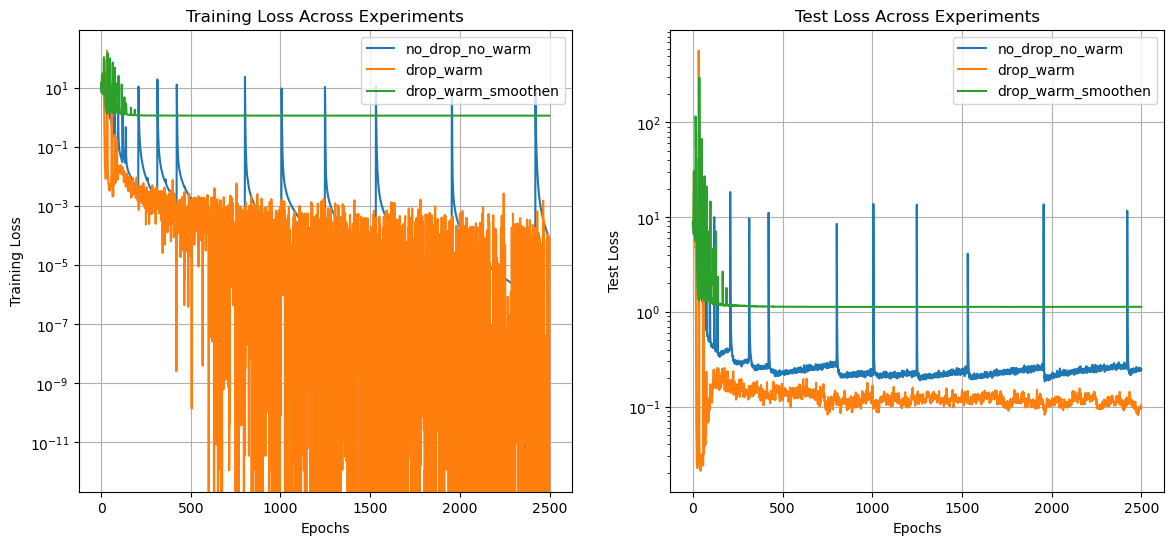

In [52]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot training losses
for exp_name, losses in train_losses.items():
    axes[0].plot(losses, label=exp_name)
axes[0].set_title("Training Loss Across Experiments")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Training Loss")
axes[0].legend()
axes[0].set_yscale("log")
axes[0].grid(True)

# Plot test losses
for exp_name, losses in test_losses.items():
    axes[1].plot(losses, label=exp_name)
axes[1].set_title("Test Loss Across Experiments")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].legend()
axes[1].set_yscale("log")
axes[1].grid(True)

# Show the plots

In [56]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params/1e6}")

Total trainable parameters: 9.880404


## Train SentencePieceModel

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import pickle
import pandas as pd
from pathlib import Path
import argparse
import yaml
import os
import sentencepiece as spm

from TransformerComponents.Encoder import Encoder
from TransformerComponents.Decoder import Decoder
from TransformerComponents.PE import PositionalEmbedding
from TransformerComponents.Transformer import Transformer
from TransformerComponents.UtilsLayers import Projection
from TransformerComponents.Optimiser import WarmupAdamOpt

YAML_PATH = "../papers/Attention Is All You Need/config.yaml"
with open(YAML_PATH, "r") as file:
    config = yaml.safe_load(file)

class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings_app = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings_app = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings_app, tgt_encodings_app, output_encodings))
        full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
        src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
        src_tensor = torch.tensor(src_seq, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
        output_tensor = torch.tensor(output_seq, dtype=torch.long)

        src_tensor = F.pad(src_tensor, (0, self.seq_len - src_tensor.size(0)), value=self.pad_token)
        tgt_tensor = F.pad(tgt_tensor, (0, self.seq_len - tgt_tensor.size(0)), value=self.pad_token)
        output_tensor = F.pad(output_tensor, (0, self.seq_len - output_tensor.size(0)), value=self.pad_token)
        encoder_mask = (src_tensor != self.pad_token).int()

        subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
        padding_mask = (tgt_tensor != self.pad_token).int()
        decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

        

        return {
            "src": src_tensor, # Seq_len
            "tgt": tgt_tensor, # seq_len
            "output": output_tensor, # seq_len
            "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
            "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
        }

    def __len__(self): 
        return len(self.paired_encodings)
    

def get_encodings(datapath, model_file):
    english_sentences = pd.read_table(Path(datapath) /  "english_small.txt",  header=None)
    hindi_sentences = pd.read_table(Path(datapath) /  "hindi_small.txt",  header=None)
    sp = spm.SentencePieceProcessor(model_file=model_file)
    english_encoded = sp.encode_as_ids(english_sentences.iloc[:, 0].to_list())
    hindi_encoded = sp.encode_as_ids(hindi_sentences.iloc[:, 0].to_list())
    return english_encoded, hindi_encoded, sp


def get_dataloaders(sp, english_encoded, tgt_encoded):
    full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=tgt_encoded, sos_token=sp.bos_id(), eos_token=sp.eos_id(),
                                        pad_token=sp.pad_id())
    train_data, test_data = random_split(full_data, [config['TRAIN_RATIO'], 1-config['TRAIN_RATIO']])
    train_dataloader = DataLoader(train_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)
    return train_dataloader, test_dataloader

def build_model(sp, device):
    vocab_size = sp.vocab_size()
    encoder_transformer = Encoder(config['N_ENCODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
    decoder_transformer = Decoder(config['N_DECODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
    src_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
    tgt_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
    projection = Projection(config['D_MODEL'], vocab_size)
    model = Transformer(encoder_transformer, decoder_transformer, src_embeddings, tgt_embeddings, projection).to(device)
    model.initialise()

    return model


def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    encoder_input = batch['src'].to(device) # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device) # B  x 1 x 1 x seq_len
    encoder_output = model.encode(encoder_input, encoder_mask)
    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[: , 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device) # shape: (B, max_len, max_len)
        other_mask =(decoder_input != pad_token).int().unsqueeze(1) # (B, 1, max_len)
        decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
        out = model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
        prediction = model.proj(out) # Expected shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1) # shape: (B, )
        next_tokens = torch.where(finished, pad_token, next_tokens)

        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)

        if finished.all():
          break

    return decoder_input


def train(model, sp, train_dataloader, test_dataloader, device, warmup_steps):
    exp_name = "drop_warm_smoothen"
    num_examples = 10
    if warmup_steps != 0:
        optimiser = WarmupAdamOpt(config['D_MODEL'], warmup_steps, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    else:
        optimiser = torch.optim.Adam(model.parameters(), lr=config['LR'], eps=1e-9)
    
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=sp.pad_id(), label_smoothing=0.1).to(device)
    losses = []
    test_losses = []
    sentences = {}
    # base_model_dir = f"/srv/scratch/z3547870/Models/{exp_name}"
    # model_dir = base_model_dir
    # if os.path.exists(base_model_dir):
    #     counter = 1 
    #     while os.path.exists(model_dir):
    #         model_dir = f"{base_model_dir}_{counter}"
    #         counter += 1

    # os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
    
    for epoch in tqdm(range(1, config['NUM_EPOCHS'] + 1)):
        model.train()
        batch_train = iter(train_dataloader)
        batch_loss = 0
        for data in batch_train:
            target_indices = data['output'].to(device) # B x seq_len

            encoder_input = data['src'].to(device) # B x seq_len
            tgt_input = data['tgt'].to(device) # B x seq_len
            encoder_mask = data['encoder_mask'].to(device) # B x 1 x 1 x seq_len
            decoder_mask = data['decoder_mask'].to(device) # B x 1 x seq_len x seq_len
            logits = model(encoder_input,  tgt_input, encoder_mask=encoder_mask, decoder_mask=decoder_mask)
            loss = loss_fn(logits.view(-1, sp.vocab_size()), target_indices.view(-1))
            batch_loss += loss.item()
            
            if warmup_steps != 0:
                optimiser.optimiser.zero_grad()
            else:
                optimiser.zero_grad()
            
            loss.backward()
            optimiser.step()

        losses.append(batch_loss / len(batch_train))


        model.eval()
        val_loss = 0
        batch_test = iter(test_dataloader)
        sample_taken = False
        for data in batch_test:
            with torch.no_grad():
                target_indices = data['output'].to(device)
                if not sample_taken and epoch % 100 == 0:
                    pred = model_prediction(model, data, config['SEQ_LEN'], device, sp.bos_id(), sp.eos_id(), sp.pad_id())
                    ints = torch.randint(low=0, high=pred.size(0), size=(num_examples,))
                    pred = pred[ints, :]
                    decoded = [sp.decode(pred.detach().cpu().tolist())]
                    actual_decoded = [sp.decode(target_indices[ints, :].detach().cpu().tolist())]
                    
                    comparison_text = []
                    for j in range(len(decoded)):
                        comparison_text.append([decoded[j], actual_decoded[j]])

                    sentences[epoch] = comparison_text
                    sample_taken = True

                encoder_input = data['src'].to(device) # B x seq_len
                tgt_input = data['tgt'].to(device) # B x seq_len
                encoder_mask = data['encoder_mask'].to(device) # B x 1 x 1 x seq_len
                decoder_mask = data['decoder_mask'].to(device) # B x 1 x seq_len x seq_len
                logits = model(encoder_input,  tgt_input, encoder_mask=encoder_mask, decoder_mask=decoder_mask)
                loss = loss_fn(logits.view(-1, sp.vocab_size()), target_indices.view(-1))
                val_loss += loss.item()

        test_losses.append(val_loss / len(batch_test))

        # if epoch % 100 == 0:
        #     model_filename = f"{model_dir}/Model_{epoch}"
        #     torch.save({
        #         'epoch': epoch,
        #         "model_state_dict": model.state_dict(),
        #         "optimiser_state_dict": optimiser.state_dict(),
        #         }, model_filename)
    
    # with open(f"/srv/scratch/z3547870/experiments/{exp_name}_train_loss.pkl", "wb") as f:
    #     pickle.dump(losses, f)    
        
    # with open(f"/srv/scratch/z3547870/experiments/{exp_name}_test_loss.pkl", "wb") as f:
    #     pickle.dump(test_losses, f)    
    
    # with open(f"/srv/scratch/z3547870/experiments/{exp_name}_sentences.pkl", "wb") as f:
    #     pickle.dump(sentences, f)    


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
english_encoded, hindi_encoded, sp = get_encodings("../data/en-hi", "../papers/Attention Is All You Need/BPE/en-hi.model")
train_dataloader, test_dataloader = get_dataloaders(sp, english_encoded, hindi_encoded)
model = build_model(sp, device)
train(model,sp, train_dataloader, test_dataloader, device, 200)


  0%|          | 0/2500 [00:01<?, ?it/s]


KeyboardInterrupt: 